# Assignment 4
## AutoEncoder to implement Anomly Detection build the model

__Autoencoders tries to minimize the reconstruction error as part of its training.__

__APPLICATION OF AUTOENCODERS:__

__Anomaly Detection: Autoencoders use the property of a neural network in a special way to accomplish some efficient methods of training networks to learn normal behavior. When an outlier data point arrives, the auto-encoder cannot codify it well. It learned to represent patterns not existing in this data. When trying to reconstruct the original data from its compact representation, the reconstruction will not resemble the original data. Thus helping to detect anomalies when they occur. The goal of such a process is to try to reconstruct the original input from the encoded data, which is critical in building an anomaly detection module.__

__**There are 3 major parts in an Autoencoder Architecture, as below:**__

__An Encoder => which reduces the dimensionality of a high dimensional dataset to a low dimensional one.__

__Code => which contains the reduced representation of the input that is fed into the decoder.__

__A Decoder =>  which expands the low-dimensional data to high-dimensional data.__

### 1)Import Libraries

In [27]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

### 2) Upload/Access the data

In [31]:
df =  pd.read_csv("C:\\Users\\Shree\\Desktop\\creditcard.csv")

In [35]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14,8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

__value_counts => Return a Series containing counts of unique values.__

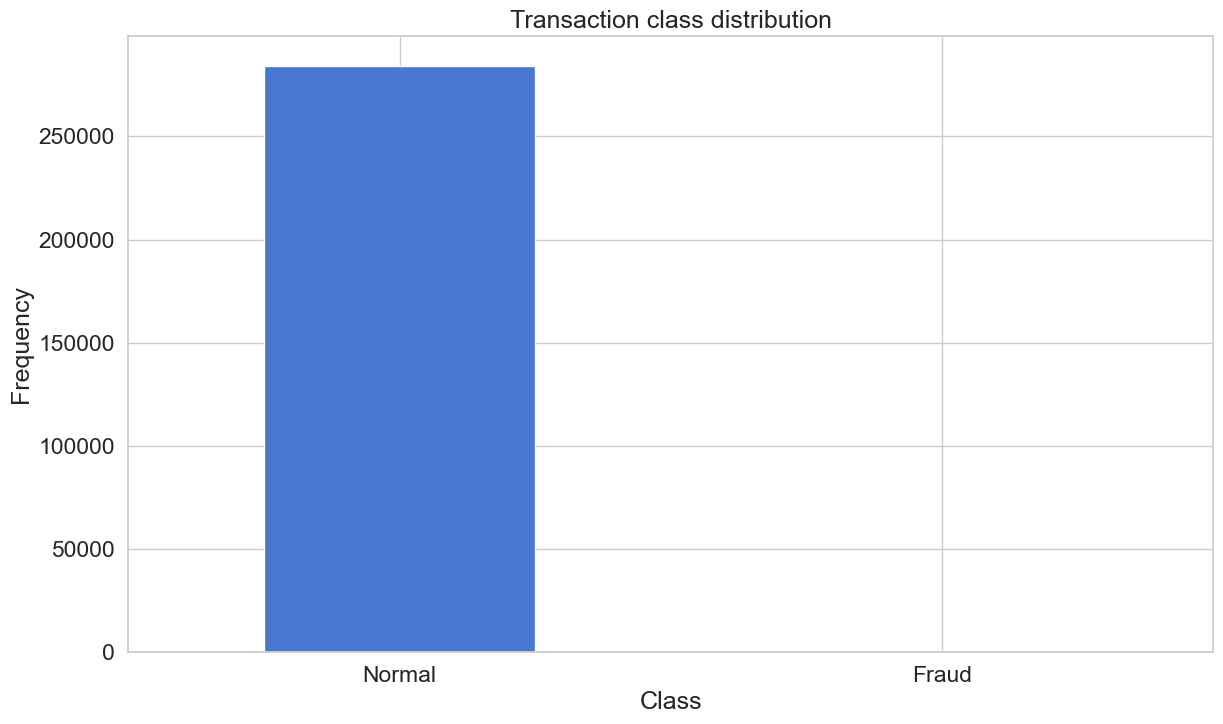

In [36]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [46]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


In [47]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

### 3) Encoder converts it into Latent Representation and Decoder networks converted back to Original

In [48]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [49]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

### 4)Compile models with Optimizer , Loss and Evaluation

In [45]:

nb_epoch = 10
batch_size = 32
early_stop = tf.keras.callbacks. EarlyStopping( monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', 
                                               restore_best_weights=True)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, early_stop]).history

Epoch 1/10
7108/7108 [==============================] - 70s 9ms/step - loss: 0.7152 - accuracy: 0.6916 - val_loss: 0.7485 - val_accuracy: 0.6937
Epoch 2/10
7108/7108 [==============================] - 23s 3ms/step - loss: 0.7145 - accuracy: 0.6918 - val_loss: 0.7496 - val_accuracy: 0.6945
Epoch 3/10
7108/7108 [==============================] - 26s 4ms/step - loss: 0.7137 - accuracy: 0.6940 - val_loss: 0.7489 - val_accuracy: 0.6921
Epoch 4/10
7108/7108 [==============================] - 22s 3ms/step - loss: 0.7138 - accuracy: 0.6934 - val_loss: 0.7478 - val_accuracy: 0.6925
Epoch 5/10
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7133 - accuracy: 0.6936 - val_loss: 0.7474 - val_accuracy: 0.6910
Epoch 6/10
7108/7108 [==============================] - 26s 4ms/step - loss: 0.7126 - accuracy: 0.6944 - val_loss: 0.7471 - val_accuracy: 0.6969
Epoch 7/10
7108/7108 [==============================] - 23s 3ms/step - loss: 0.7130 - accuracy: 0.6945 - val_loss: 0.7461 - val_ac

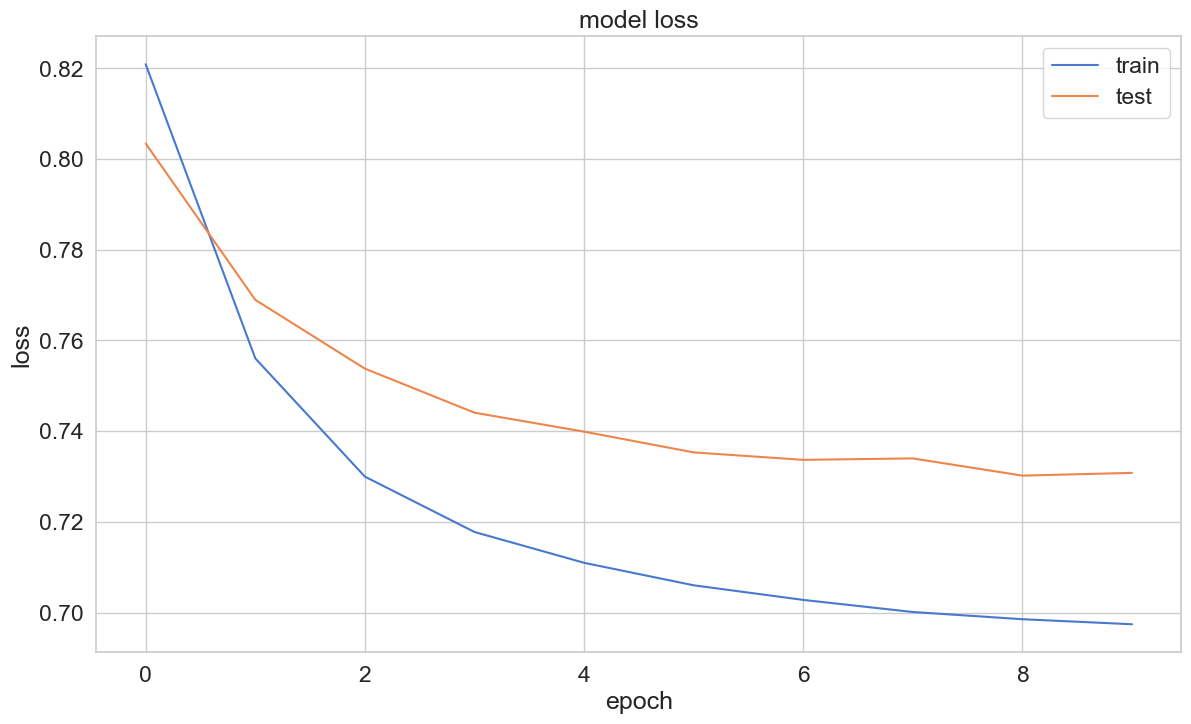

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [17]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 4s 2ms/step


In [18]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [19]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.729891,0.001720
std,3.415739,0.041443
min,0.037539,0.000000
25%,0.238788,0.000000
50%,0.390333,0.000000
75%,0.619894,0.000000
max,259.809715,1.000000


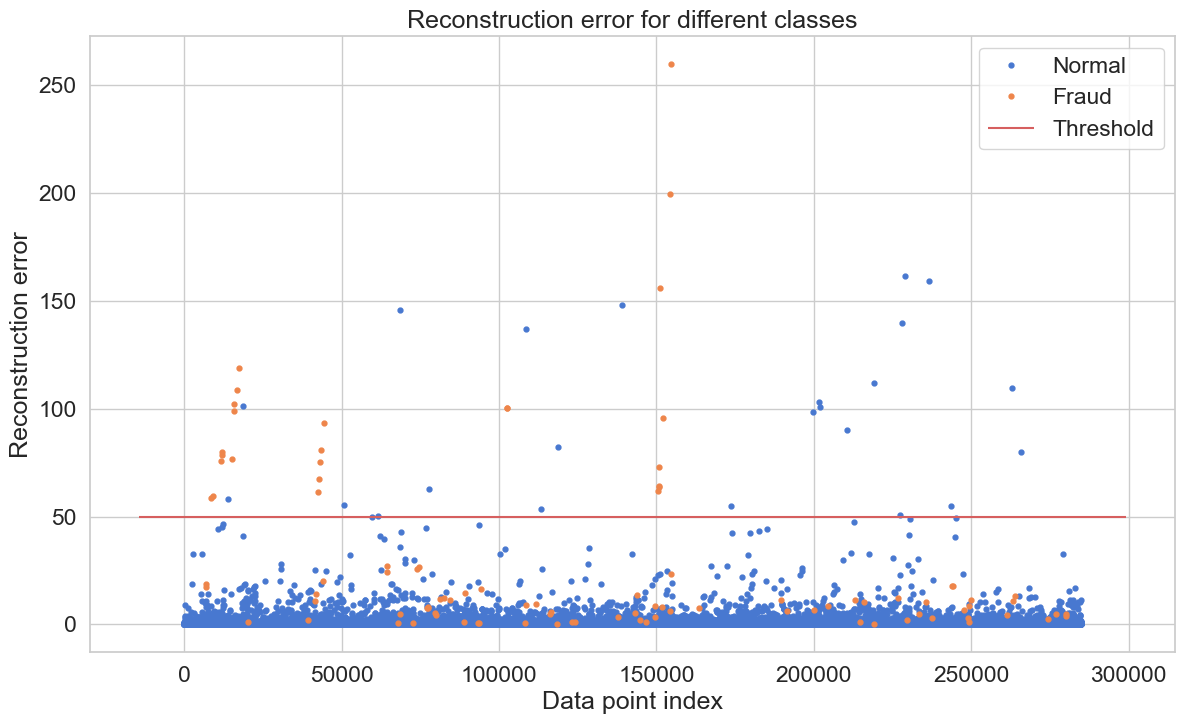

In [20]:
threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [21]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

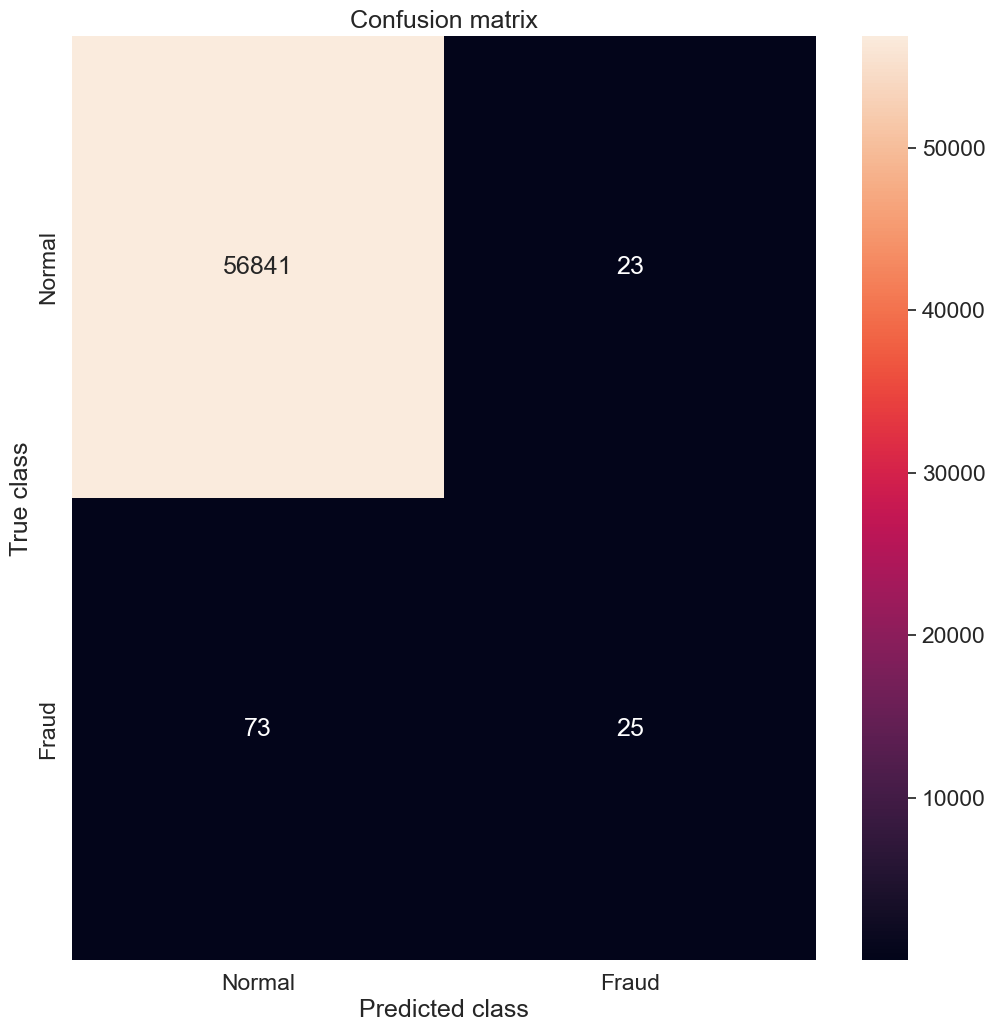

In [22]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [23]:
error_df['pred'] = y_pred

In [24]:
print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred'])) 
print("Recall:",recall_score(error_df['true_class'],error_df['pred']))
print("Precision:",precision_score(error_df['true_class'],error_df['pred']))

Accuracy: 0.9983146659176293
Recall: 0.25510204081632654
Precision: 0.5208333333333334
